In [1]:
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans

In [10]:
drawing = False
brush_size = 6
mask = None

def draw_freehand(event, x, y, flags, param):
    global drawing, mask, image

    if event == cv2.EVENT_LBUTTONDOWN:  # Start drawing
        drawing = True
        cv2.circle(mask, (x, y), brush_size, 255, -1)

    elif event == cv2.EVENT_MOUSEMOVE:  # Draw while moving the mouse
        if drawing:
            cv2.circle(mask, (x, y), brush_size, 255, -1)

    elif event == cv2.EVENT_LBUTTONUP:  # Stop drawing and apply segmentation
        drawing = False
        apply_segmentation()

def apply_segmentation():
    global image, mask

    # Extract selected region using the mask
    selected_pixels = cv2.bitwise_and(image, image, mask=mask)

    # Reshape selected region for clustering
    pixels = selected_pixels.reshape(-1, 3)
    pixels = pixels[np.any(pixels != 0, axis=1)]  # Remove black (unselected) pixels

    if pixels.size == 0:
        print("No pixels selected for segmentation.")
        return

    # # Estimate bandwidth for Mean Shift
    # bandwidth = estimate_bandwidth(pixels, quantile=0.4, n_samples=500)

    # # Apply Mean Shift clustering
    # mean_shift = MeanShift(bandwidth=5 , bin_seeding=True)
    # mean_shift.fit(pixels)

    # # Get cluster centers and labels
    # labels = mean_shift.labels_
    # cluster_centers = mean_shift.cluster_centers_

    # Define number of clusters (K)
    num_clusters = 2  # You can change this value based on your needs

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(pixels)

    # Get cluster centers and labels
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    # Change lighter cluster centers to white
    lightness_threshold = max(list(cluster_centers.mean(axis=1)))  # Threshold for considering a color "light"
    # lightness_threshold = 60
    for i, center in enumerate(cluster_centers):
        if round(np.mean(center),2) >= round(lightness_threshold,2):  # Calculate average intensity
            cluster_centers[i] = [255, 255, 255]  # Set to white

    # Create segmented pixels
    segmented_pixels = cluster_centers[labels].astype(np.uint8)
    segmented_region = np.zeros_like(selected_pixels)
    segmented_region[np.any(selected_pixels != 0, axis=2)] = segmented_pixels

    # Add the segmented region to the main image
    white_mask = cv2.inRange(segmented_region, (255, 255, 255), (255, 255, 255))
    image[white_mask == 255] = [0, 0, 255]

    # Clear the mask for the next iteration
    mask.fill(0)


In [11]:
# Load the grayscale PNG images
images_path = './crops/'
import os
images = os.listdir(images_path)
images = [i for i in images if i.endswith('.png')]
images = [images_path + i for i in images]

def load_preprocess_image(image_path):
    image = cv2.imread(image_path)
    return image

image = load_preprocess_image(images[0])
# cv2.imshow("Image", image)
# key = cv2.waitKey(0)

In [12]:
for image_path in images:
    # Load the image
    # image_path = 'aligned_250.png'  # Replace with the path to your image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        exit()

    # cv2.putText(image, f'brush_size is {brush_size}')

    # Create a black mask with the same dimensions as the image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", draw_freehand)

    while True:
        # Display the current state of the image
        display_image = cv2.addWeighted(image, 0.8, cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), 0.2, 0)
        cv2.imshow("Image", display_image)

        key = cv2.waitKey(1)

        # Press 'q' to quit
        if key == ord("q"):
            os.remove(image_path)
            cv2.imwrite('./mask/' + image_path.split('/')[-1], image)
            break
        if key == ord("r"):
            image = cv2.imread(image_path)

cv2.destroyAllWindows()


KeyboardInterrupt: 

In [13]:
import cv2
import os
import numpy as np

# Input and output directory paths
input_dir = "./mask/"  # Replace with your image directory
output_dir = "./final_mask/"  # Replace with your desired output directory

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        # Read the image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Failed to read {filename}, skipping.")
            continue

        # Create a binary mask: red color (0, 0, 255) -> 1, others -> 0
        mask = np.zeros(image.shape[:2], dtype=np.uint8)  # Initialize mask with 0s
        red_pixels = (image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 255)
        mask[red_pixels] = 1  # Set red pixels to 1

        # Save the binary mask
        mask_path = os.path.join(output_dir, os.path.splitext(filename)[0] + ".png")
        cv2.imwrite(mask_path, mask * 255)  # Scale mask to 0-255 for saving as an image
        print(f"Processed and saved mask for {filename}")


FileNotFoundError: [WinError 3] The system cannot find the path specified: './mask/'

In [4]:
import os
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 8
NUM_CLASSES = 2  # Background and foreground
EPOCHS = 20
LR = 1e-3

In [5]:
# Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.filenames = [
            f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.filenames[idx])

        # Load image and mask
        image = Image.open(img_path).convert("RGB").resize(IMAGE_SIZE)
        mask = Image.open(mask_path).convert("L").resize(IMAGE_SIZE)

        # Convert mask to binary
        mask = np.array(mask) > 127
        mask = torch.tensor(mask, dtype=torch.long)  # Mask should have integer labels for PyTorch
        
        if self.transform:
            image = self.transform(image)

        return image, mask

# Define transformations
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load data
image_dir = "./images/"  # Replace with the image directory
mask_dir = "./masks/"    # Replace with the mask directory

In [6]:
dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# Load DeepLabV3 model
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1))
model = model.to(DEVICE)

c:\Users\Windows\anaconda3\envs\gpu-pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows\anaconda3\envs\gpu-pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
LR = 1e-2
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, masks in train_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)


Epoch 1/20, Train Loss: 0.1845, Val Loss: 0.1553
Epoch 2/20, Train Loss: 0.1473, Val Loss: 0.1494
Epoch 3/20, Train Loss: 0.1420, Val Loss: 0.1441
Epoch 4/20, Train Loss: 0.1401, Val Loss: 0.1440
Epoch 5/20, Train Loss: 0.1388, Val Loss: 0.1422
Epoch 6/20, Train Loss: 0.1381, Val Loss: 0.1426
Epoch 7/20, Train Loss: 0.1380, Val Loss: 0.1419
Epoch 8/20, Train Loss: 0.1370, Val Loss: 0.1419
Epoch 9/20, Train Loss: 0.1367, Val Loss: 0.1429
Epoch 10/20, Train Loss: 0.1367, Val Loss: 0.1417
Epoch 11/20, Train Loss: 0.1361, Val Loss: 0.1428
Epoch 12/20, Train Loss: 0.1361, Val Loss: 0.1425
Epoch 13/20, Train Loss: 0.1354, Val Loss: 0.1442
Epoch 14/20, Train Loss: 0.1354, Val Loss: 0.1425
Epoch 15/20, Train Loss: 0.1350, Val Loss: 0.1421
Epoch 16/20, Train Loss: 0.1342, Val Loss: 0.1431
Epoch 17/20, Train Loss: 0.1344, Val Loss: 0.1511


KeyboardInterrupt: 

In [16]:
# Save the model
torch.save(model.state_dict(), "deeplabv3_segmentation.pth")

In [17]:
def denormalize_image(image, mean, std):
    """
    Denormalize a normalized image tensor.
    Args:
        image (Tensor): Normalized image tensor (C, H, W).
        mean (list): Mean values used for normalization.
        std (list): Standard deviation values used for normalization.
    Returns:
        Tensor: Denormalized image tensor.
    """
    mean = torch.tensor(mean).view(3, 1, 1).to(image.device)
    std = torch.tensor(std).view(3, 1, 1).to(image.device)
    denormalized_image = image * std + mean
    return denormalized_image.clamp(0, 1)  # Ensure values are within [0, 1]

def visualize_sample(image, mask, prediction, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Visualize an image, its ground truth mask, and the model prediction.
    Args:
        image (Tensor): Normalized input image tensor (C, H, W).
        mask (Tensor): Ground truth mask (H, W).
        prediction (Tensor): Predicted mask (H, W).
        mean (list): Mean values for normalization.
        std (list): Standard deviation values for normalization.
    """
    # Denormalize the image
    denormalized_image = denormalize_image(image, mean, std).permute(1, 2, 0).cpu().numpy()

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(denormalized_image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask.cpu().numpy(), cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction.cpu().numpy(), cmap="gray")

    plt.show()



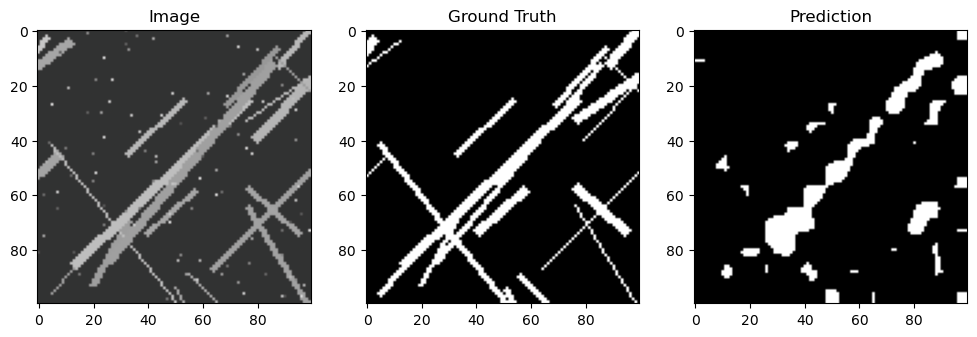

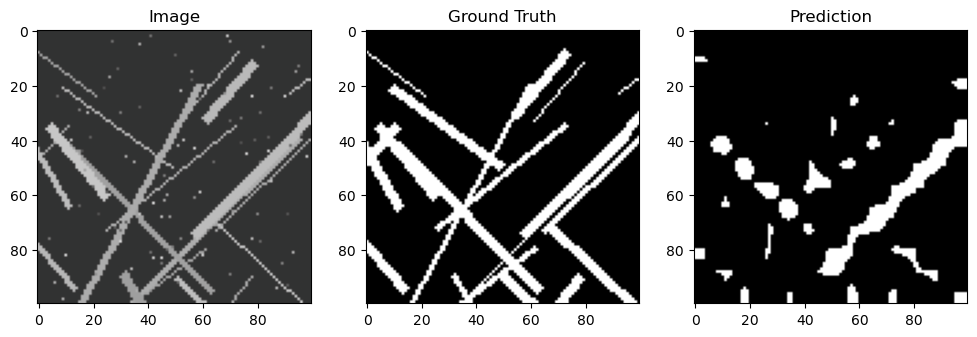

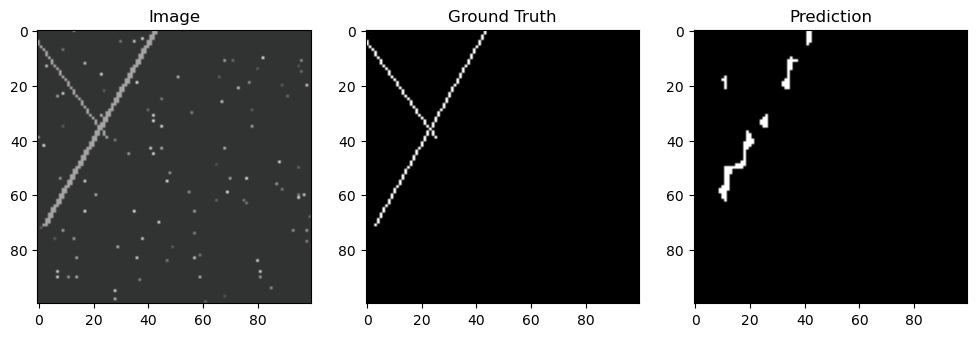

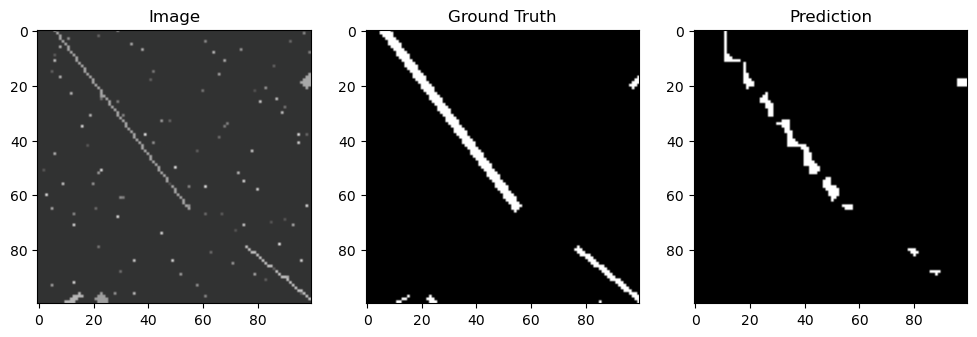

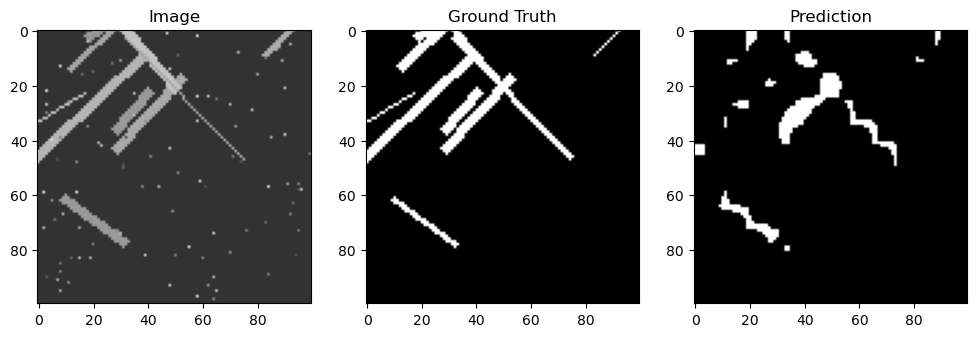

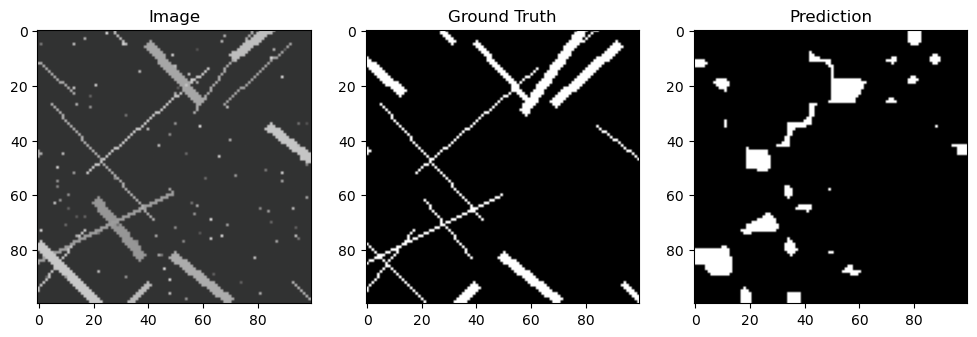

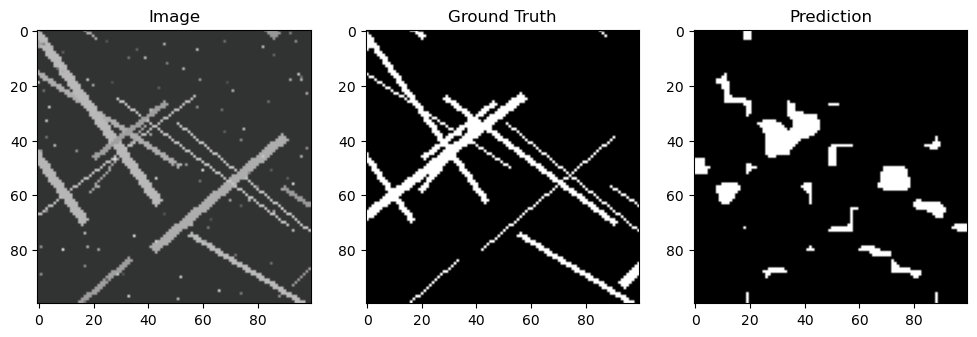

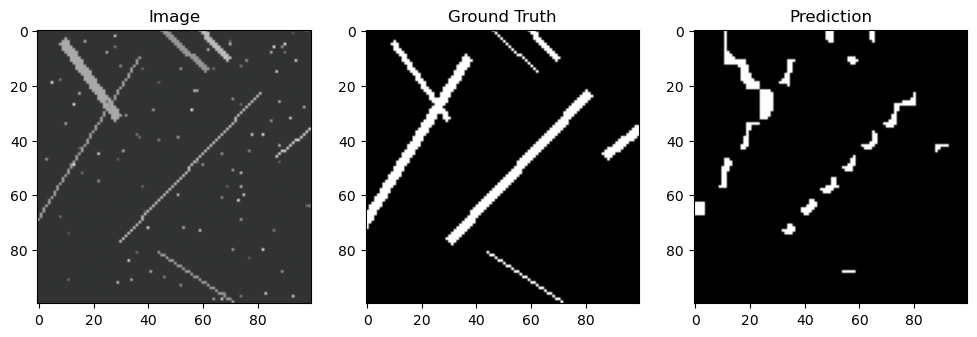

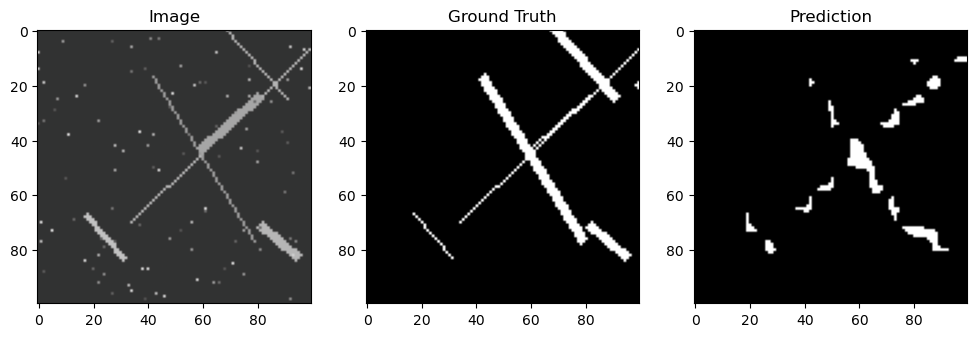

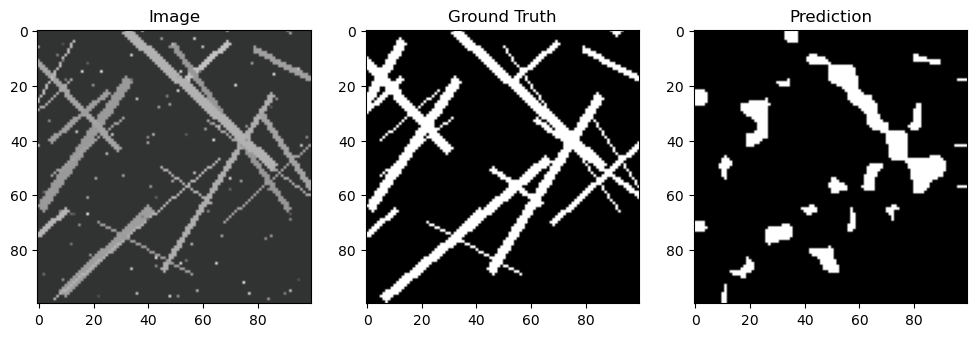

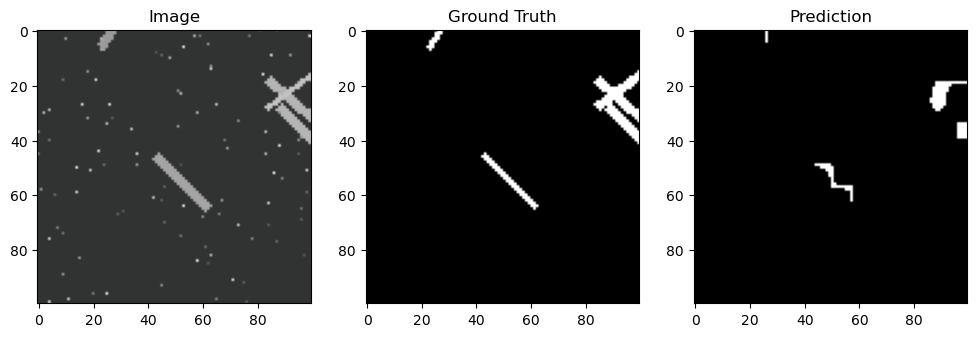

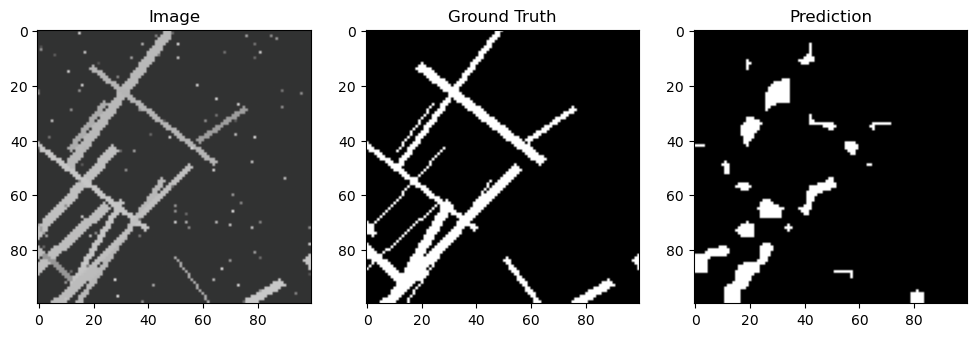

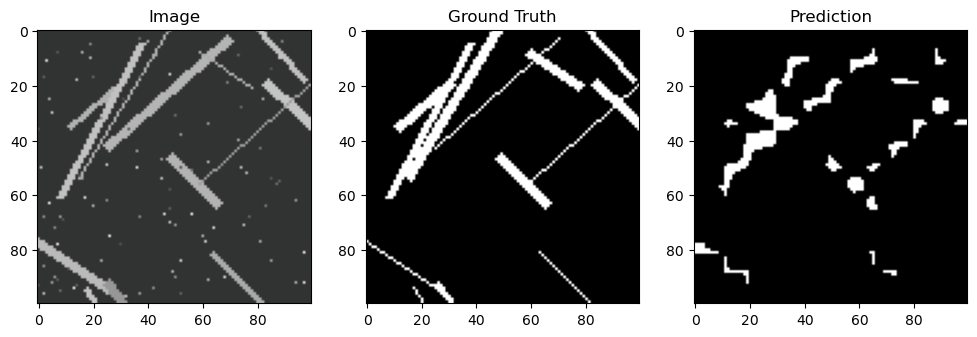

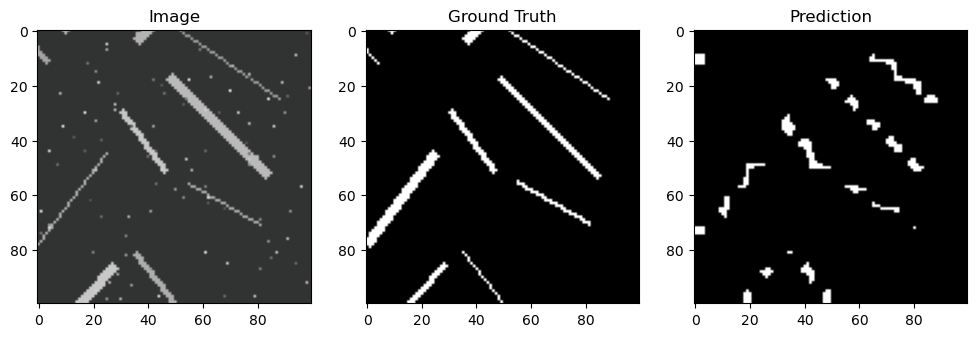

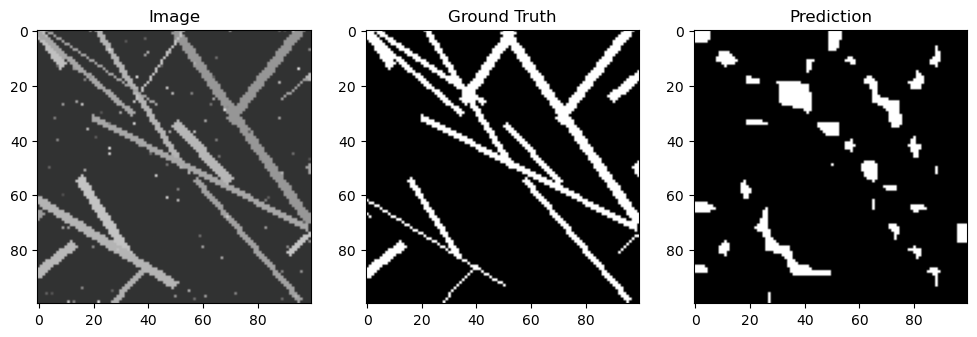

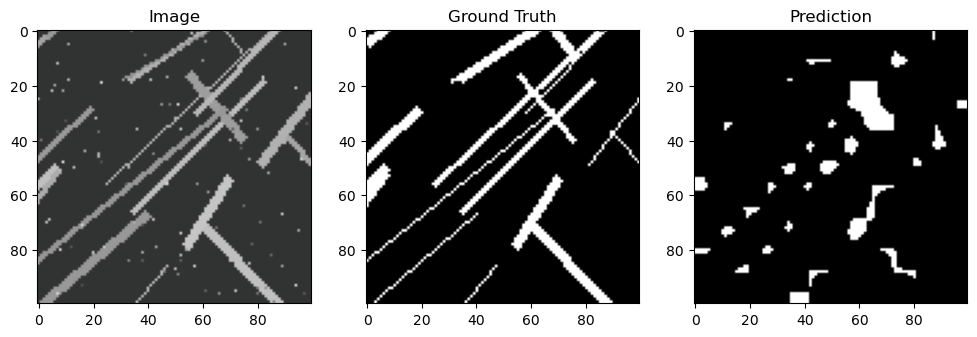

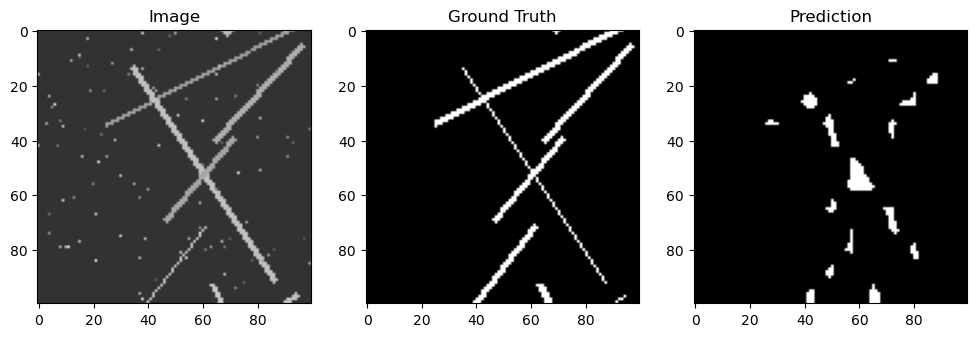

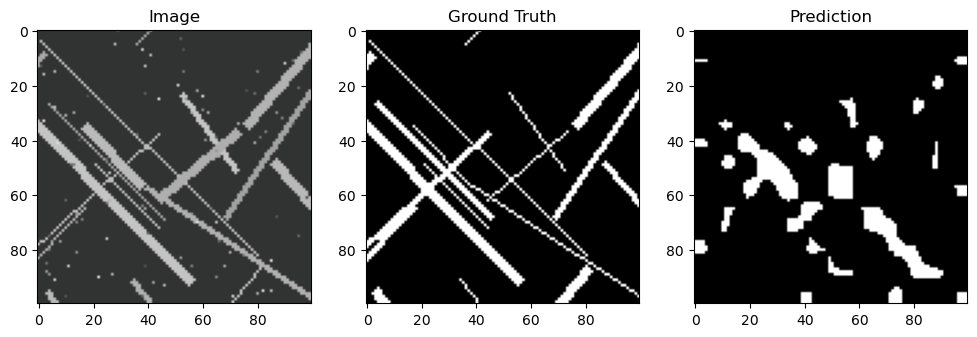

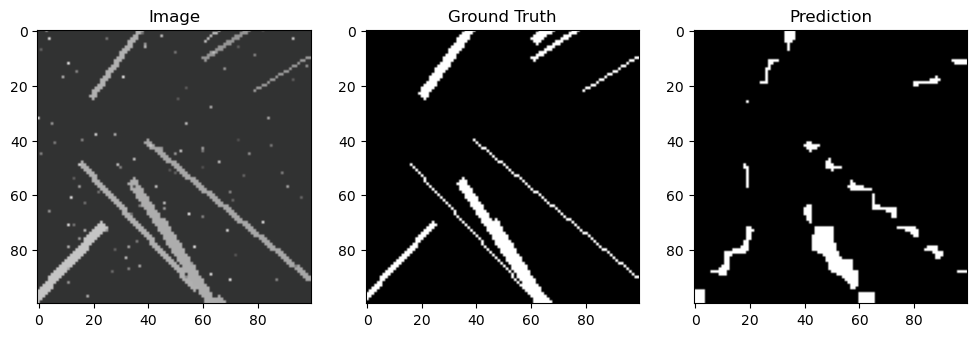

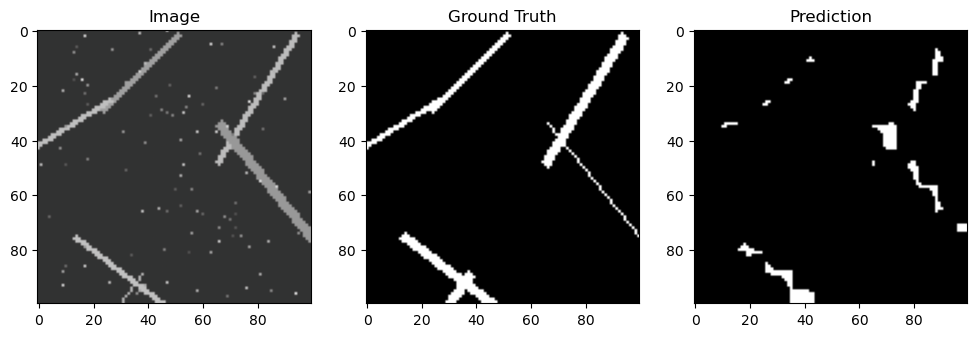

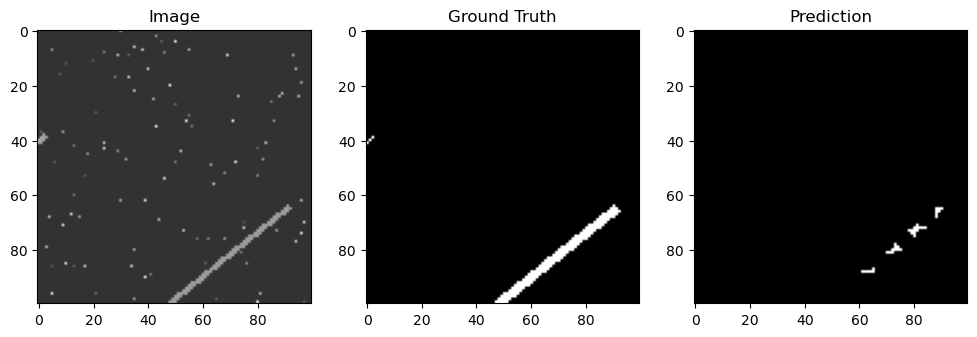

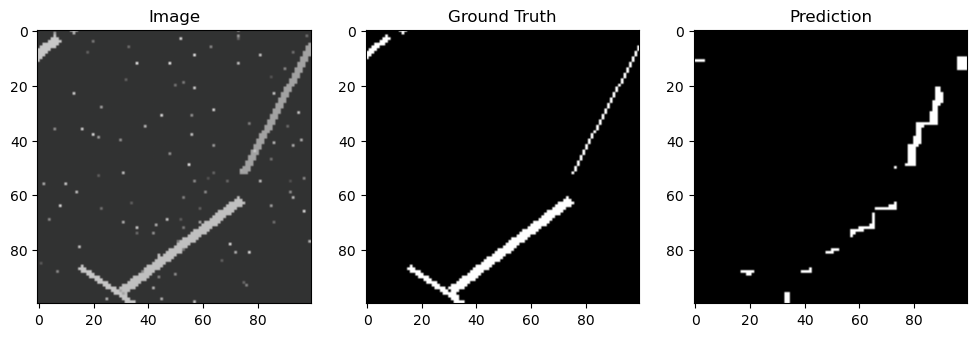

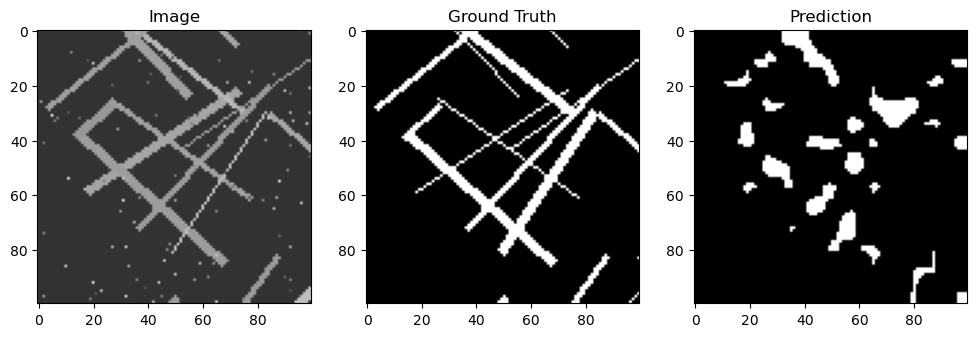

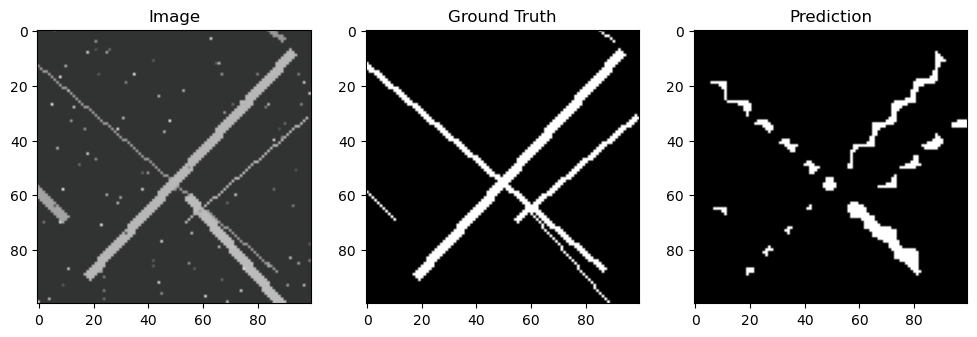

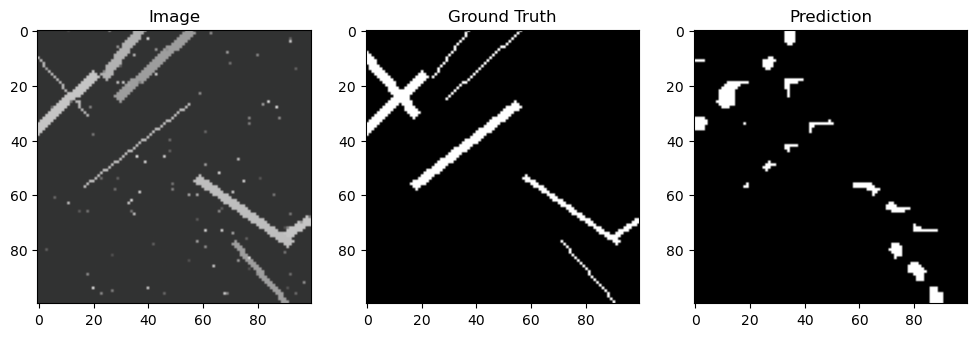

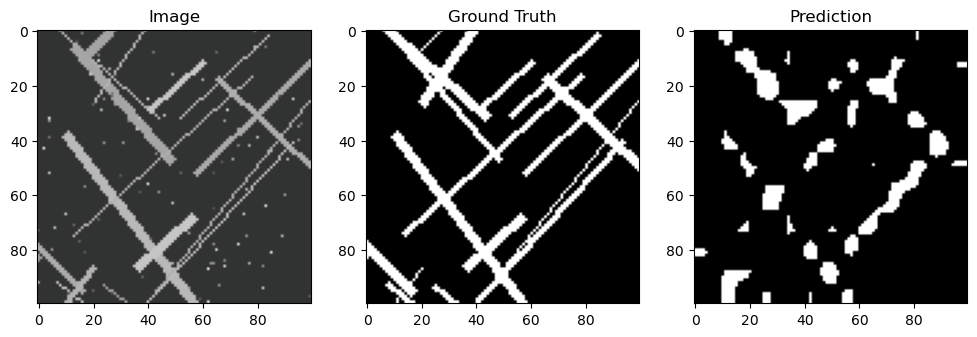

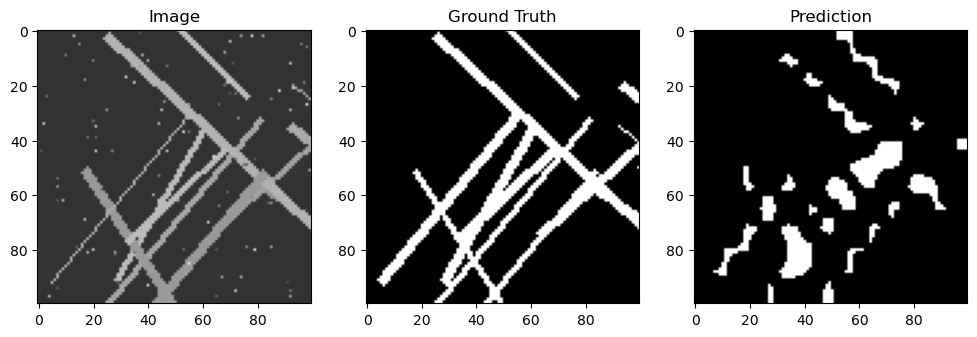

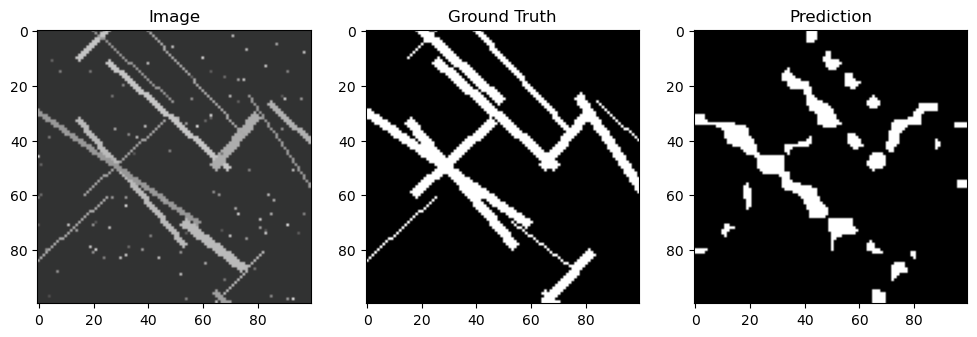

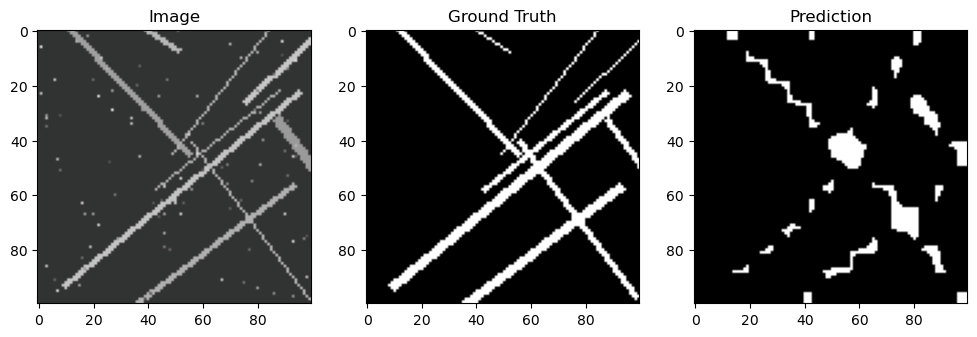

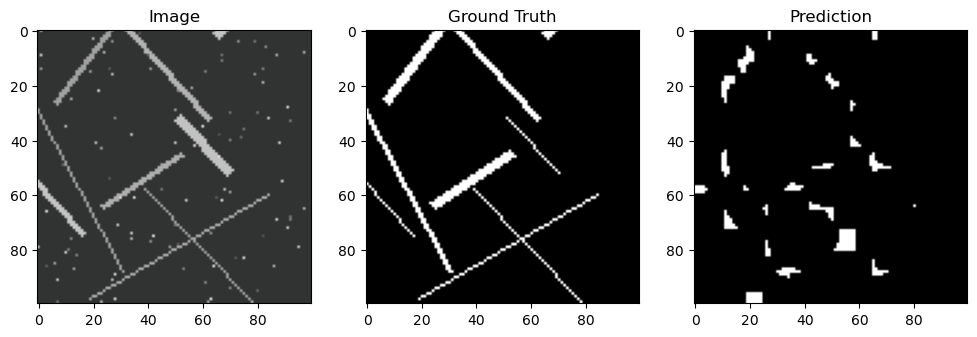

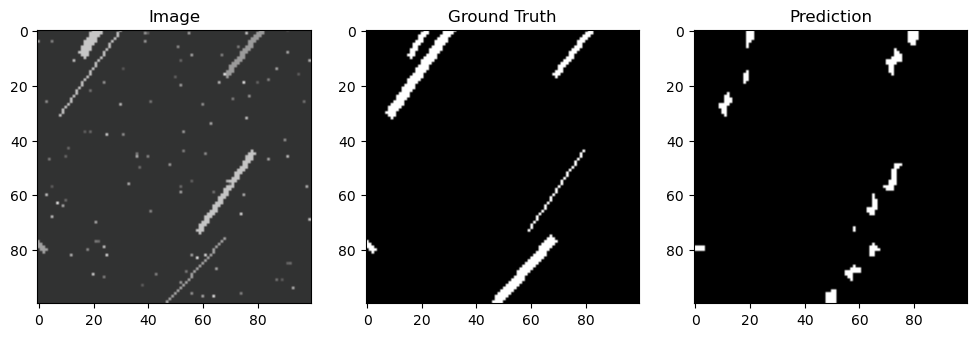

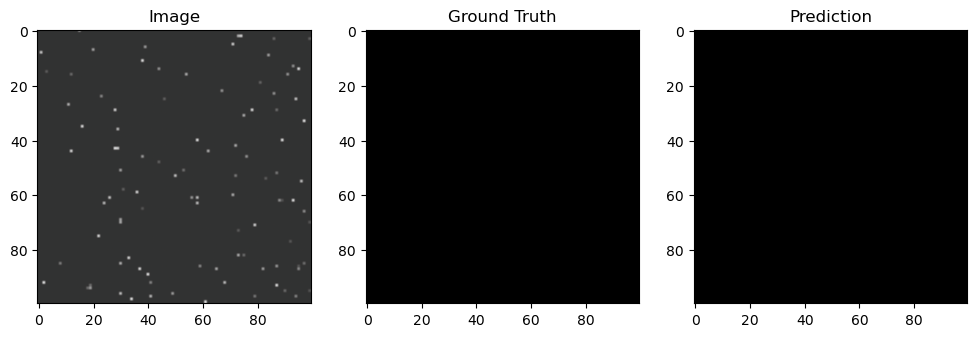

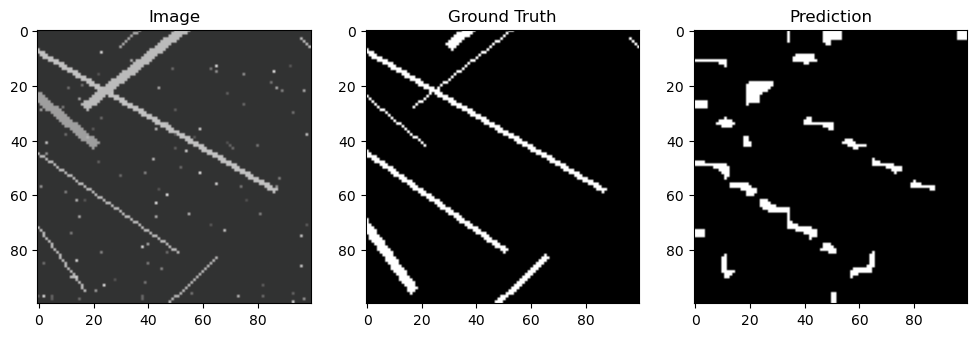

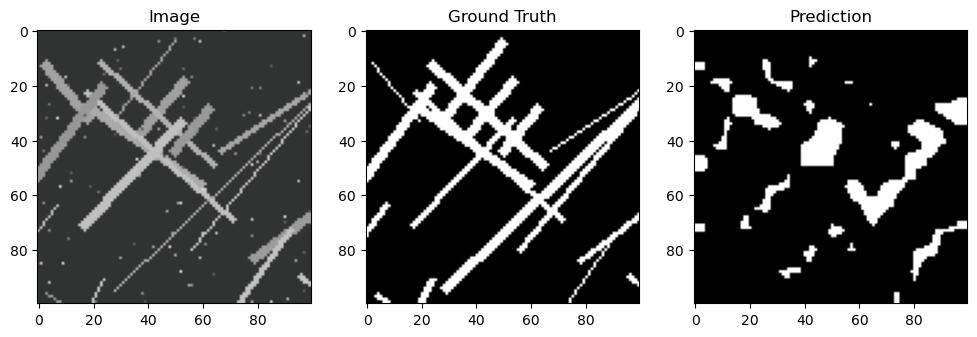

In [18]:
for i in range(100):
    # Test the model
    model.eval()
    sample_image, sample_mask = val_dataset[i]
    sample_image = sample_image.to(DEVICE).unsqueeze(0)
    with torch.no_grad():
        output = model(sample_image)["out"].argmax(1).squeeze(0)

    visualize_sample(sample_image.squeeze(0), sample_mask, output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2445416..-0.11381256].


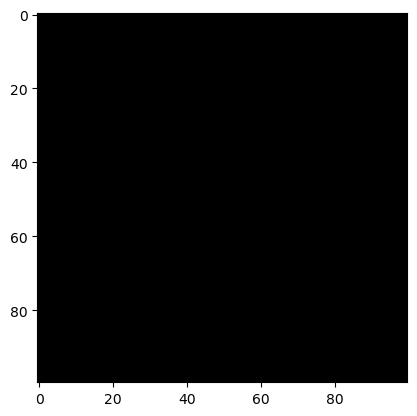

In [33]:
plt.imshow(sample_image.squeeze(0).permute(1, 2, 0).cpu().numpy())